In [124]:
%%time
import numpy as np 
import pandas as pd
import os
import pickle as pk
import matplotlib.pyplot as plt
from random import randint
# Machine Learning
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.engine.topology import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, LSTM, Flatten, 
                          Dropout, Embedding, BatchNormalization)
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Wall time: 0 ns


# Loading The Model

In [6]:
def load_seq(path):
    with open(path,'rb') as file:
        seqs = pk.load(file)
        print(f'Sequences loaded from: {path}')
    
    return seqs

In [7]:
location = r'E:\Documents\My Projects\Text Generation\data\HEAM.seq'
sequences = load_seq(location)
sequences[0]

Sequences loaded from: E:\Documents\My Projects\Text Generation\data\HEAM.seq


'introduction the twothousandyearold assumptionon december the deadliest school shooting in us history took place at sandy hook elementary school in newtown connecticut twentysix people inside the school including twenty children were massacred by a lone gunman several weeks after this horror i watched the governor of connecticut dannel malloy give his'

# Encoding the sequences
The word embedding layer expects input sequences to be comprised of integers.
We can map each word in our vocabulary to a unique integer and encode our input sequences. Later, when we make predictions, we can convert the prediction to numbers and look up their associated words in the same mapping.

In [11]:
encoder = Tokenizer()
encoder.fit_on_texts(sequences)
encoded_sequences = encoder.texts_to_sequences(sequences)

In [20]:
print(f'{sequences[0][:13]} ---- mapped to ---> {encoded_sequences[0][:13]}')

introduction  ---- mapped to ---> [5586, 1, 10246, 10245, 10244, 1, 10243, 570, 2271, 6, 107, 644, 1010]


# Mapping the Encoding
We can access the mapping of words to integers as a dictionary attribute called word_index on the Tokenizer object.
We need to know the size of the vocabulary for defining the embedding layer later. We can determine the vocabulary by calculating the size of the mapping dictionary.

Words are assigned values from 1 to the total number of words (e.g. 7,409). The Embedding layer needs to allocate a vector representation for each word in this vocabulary from index 1 to the largest index and because indexing of arrays is zero-offset, the index of the word at the end of the vocabulary will be 7,409; that means the array must be 7,409 + 1 in length.

In [64]:
vocab_size = len(encoder.word_index) + 1
vocab_size

10248

# Sequence Inputs and Output
Now that we have encoded the input sequences, we need to separate them into input (X) and output (y) elements.

We can do this with array slicing.

After separating, we need to one hot encode the output word. This means converting it from an integer to a vector of 0 values, one for each word in the vocabulary, with a 1 to indicate the specific word at the index of the words integer value.

This is so that the model learns to predict the probability distribution for the next word and the ground truth from which to learn from is 0 for all words except the actual word that comes next.

Keras provides the to_categorical() that can be used to one hot encode the output words for each input-output sequence pair.

Finally, we need to specify to the Embedding layer how long input sequences are. We know that there are 50 words because we designed the model, but a good generic way to specify that is to use the second dimension (number of columns) of the input data’s shape. That way, if you change the length of sequences when preparing data, you do not need to change this data loading code; it is generic.

# Split Input and Output Features
It is common to split your loaded data into input variables (X) and the output variable (y).

We can do this by slicing all rows and all columns up to, but before the last column, then separately indexing the last column.

For the input features, we can select all rows and all columns except the last one by specifying ‘:’ for in the rows index, and :-1 in the columns index.

In [45]:
# convert from list to a numpy array
sequences = np.array(encoded_sequences)
x, y = sequences[:,:-1], sequences[:,-1]
# the classes are the unique words
y = to_categorical(y, num_classes=vocab_size)
seq_length = x.shape[1]
seq_length

50

# Fit Model
We can now define and fit our language model on the training data.

The learned embedding needs to know the size of the vocabulary and the length of input sequences as previously discussed. It also has a parameter to specify how many dimensions will be used to represent each word. That is, the size of the embedding vector space.

Common values are 50, 100, and 300. We will use 50 here, but consider testing smaller or larger values.

We will use a two LSTM hidden layers with 100 memory cells each. More memory cells and a deeper network may achieve better results.

A dense fully connected layer with 100 neurons connects to the LSTM hidden layers to interpret the features extracted from the sequence. The output layer predicts the next word as a single vector the size of the vocabulary with a probability for each word in the vocabulary. A softmax activation function is used to ensure the outputs have the characteristics of normalized probabilities.

__input_length:__ Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).


In [67]:
# Model creation
model = Sequential()
# input dimensions: vocab_size
# output dimensions: vector_size
model.add(Embedding(vocab_size, 75, input_length = seq_length))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dropout(.25))
model.add(Bidirectional(LSTM(100, return_sequences = True)))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(.25))
model.add(Dense(vocab_size, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 75)            768600    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 50, 200)           140800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 200)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 50, 200)           240800    
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 200)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)             

In [68]:
batches = 128
epochs = 100
checkpoint = ModelCheckpoint(filepath = r'E:\Documents\My Projects\Text Generation\Models\BiLSTM_Language_Generation.hdf5',
                            verbose = 1, save_best_only=True)
stopping = EarlyStopping(monitor='loss',patience=5)

callbacks = [checkpoint,stopping]
history = model.fit(x, y, batch_size=batches, epochs = epochs, callbacks = callbacks, validation_split=.1)

C:\Users\gabe5\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
123894/123894 [==============================] - 451s 4ms/step - loss: 6.9091 - accuracy: 0.0467
Epoch 2/100


C:\Users\gabe5\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\gabe5\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


123894/123894 [==============================] - 473s 4ms/step - loss: 6.5643 - accuracy: 0.0698
Epoch 3/100
123894/123894 [==============================] - 486s 4ms/step - loss: 6.2763 - accuracy: 0.0905
Epoch 4/100
123894/123894 [==============================] - 482s 4ms/step - loss: 6.0066 - accuracy: 0.1040
Epoch 5/100
123894/123894 [==============================] - 483s 4ms/step - loss: 5.7667 - accuracy: 0.1151
Epoch 6/100
123894/123894 [==============================] - 484s 4ms/step - loss: 5.5450 - accuracy: 0.1263
Epoch 7/100
123894/123894 [==============================] - 481s 4ms/step - loss: 5.3382 - accuracy: 0.1358
Epoch 8/100
123894/123894 [==============================] - 485s 4ms/step - loss: 5.1376 - accuracy: 0.1451
Epoch 9/100
123894/123894 [==============================] - 480s 4ms/step - loss: 4.9512 - accuracy: 0.1537
Epoch 10/100
123894/123894 [==============================] - 482s 4ms/step - loss: 4.7723 - accuracy: 0.1603
Epoch 11/100
123894/123894 [==

123894/123894 [==============================] - 504s 4ms/step - loss: 2.0584 - accuracy: 0.4916
Epoch 77/100
123894/123894 [==============================] - 495s 4ms/step - loss: 2.0549 - accuracy: 0.4914
Epoch 78/100
123894/123894 [==============================] - 491s 4ms/step - loss: 2.0386 - accuracy: 0.4940
Epoch 79/100
123894/123894 [==============================] - 493s 4ms/step - loss: 2.0208 - accuracy: 0.5000
Epoch 80/100
123894/123894 [==============================] - 489s 4ms/step - loss: 2.0046 - accuracy: 0.5014
Epoch 81/100
123894/123894 [==============================] - 486s 4ms/step - loss: 1.9919 - accuracy: 0.5045
Epoch 82/100
123894/123894 [==============================] - 492s 4ms/step - loss: 1.9846 - accuracy: 0.5056
Epoch 83/100
123894/123894 [==============================] - 488s 4ms/step - loss: 1.9752 - accuracy: 0.5056
Epoch 84/100
123894/123894 [==============================] - 493s 4ms/step - loss: 1.9645 - accuracy: 0.5091
Epoch 85/100
123894/123

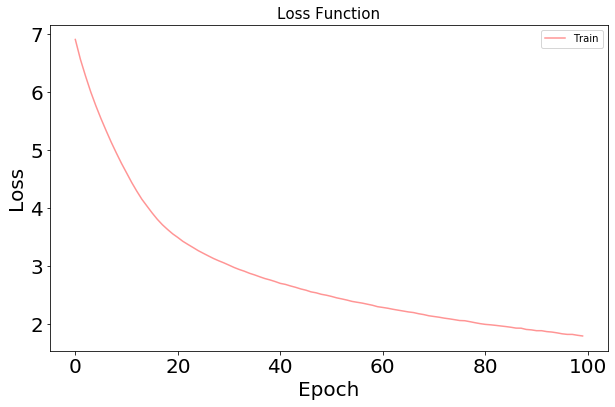

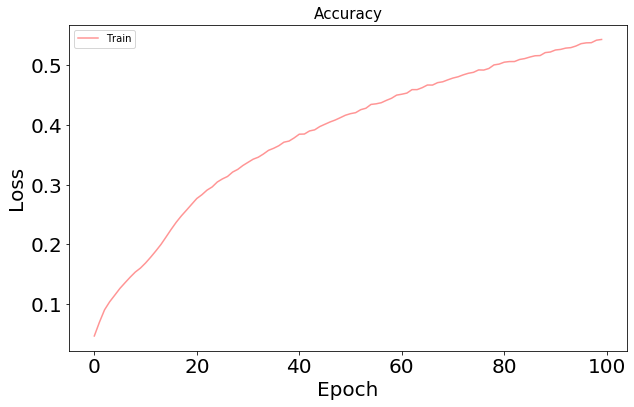

In [72]:
# plot the loss function #342b38
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(history.history['loss'],color = '#ff9595',label = 'Train')
#ax.plot(history.history['val_loss'],color = '#342b38',label = 'val')
ax.set_xlabel('Epoch',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.set_title('Loss Function',fontsize = 15)
ax.legend()
ax.tick_params(labelsize=20)

# plot the accuracy
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(history.history['accuracy'],color = '#ff9595',label = 'Train')
#ax.plot(history.history['val_accuracy'],color = '#342b38',label = 'val')
ax.set_xlabel('Epoch',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.set_title('Accuracy',fontsize = 15)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# this function will convert all o the digits into words

In [75]:
model.save( r'E:\Documents\My Projects\Text Generation\Models\BiLSTM_Language_Generation.hdf5')
# save the tokenizer
filename =  r'E:\Documents\My Projects\Text Generation\Models\encoder.pkl'
with open(filename, 'wb') as file:
    pk.dump(encoder,file)

# Evaluation and Testing
Now that we have a trained language model, we can use it.
In this case, we can use it to generate new sequences of text that have the same statistical properties as the source text.

We need the text so that we can choose a source sequence as input to the model for generating a new sequence of text.

The model will require 50 words as input.

Later, we will need to specify the expected length of input. We can determine this from the input sequences by calculating the length of one line of the loaded data and subtracting 1 for the expected output word that is also on the same line.

In [73]:
score = model.evaluate(x,y,verbose=0)
print(f"Training Accuracy: {score[1]}")

Training Accuracy: 0.819789469242096


In [87]:
def load_sequences(path, binary = True):
    ''' function that is used to load the text sequences from either
        a binary pickle file or a text file. returns a list of sequences 
        and the expected sequence length'''
    if binary:
        with open(path,'rb') as file:
            seqs = pk.load(file)
            print(f'Sequences loaded from: {path}')
    else:
        with open(path,'r') as file:
            doc = file.read()
            seqs = doc.split('\n')
            
      
    seq_length = len(seqs[0].split()) - 1
    return seqs, seq_length


def load_encoder(path):
    with open(path,'rb') as file:
        encoder = pk.load(file)
        print(f'Sequences loaded from: {path}')
    
    return encoder


def load_network(path):
    model = load_model(path)
    return model

def generate_seed(sequences):
    section = randint(0,len(sequences))
    seed_text = sequences[section]
    print(f'Generated from section: {section}')
    return seed_text
    

In [147]:
class Predictor:
    ''' class to load models, encoders, and other methods that help in making predictions '''
    def __init__(self):
        self.encoder = None
        self.model = None
        self.sequences = None
        self.seq_length = None
        self.seed_text = None
        self.encoded_seed = None
    
    def load_sequences(self,path, binary = True):
        ''' function that is used to load the text sequences from either
        a binary pickle file or a text file. returns a list of sequences 
        and the expected sequence length'''
    
        # checks if the file is serialized or not
        if binary:
            with open(path,'rb') as file:
                # loads the sequences 
                self.sequences = pk.load(file)
                print(f'Sequences loaded from: {path}')
                
        # loads the file from an unserialized format
        else:
            with open(path,'r') as file:
                doc = file.read()
                self.sequences = doc.split('\n')

        # seq_len is a vector of size 50
        self.seq_length = len(self.sequences[0].split()) - 1
        return self.sequences, self.seq_length
    
    def load_encoder(self,path):
        with open(path,'rb') as file:
            self.encoder = pk.load(file)
            print(f'Sequences loaded from: {path}')

        return self.encoder
    
    def load_network(self,path):
        self.model = load_model(path)
        return model
    
    def generate_seed(self,sequences = None):
        self.sequences = self.sequences if sequences is None else sequences
        section = randint(0,len(self.sequences))
        self.seed_text = self.sequences[section]
        print(f'Generated from section: {section}')
        return self.seed_text
    
    def pad_input_sequence(self,seed = None):
        # the seed text must be encoded to integers using 
        # the same tokenizer that we used when training the model.
        if self.encoder is None:
            raise TypeError(f'Encoder can not be of type: {self.encoder}')
        
        # load the input sequnce 
        seed = self.seed_text if seed is None else seed
        self.encoded_seed = self.encoder.texts_to_sequences([seed])[0]
        # Truncate the sequence to a fixed length 
        self.encoded_seed = pad_sequences([encoded_seed], maxlen = seq_length, truncating='pre')
        return self.encoded_seed
    
    def generate_sequence(self, model = None, seed = None, seq_len = None, output_len = 100):
        
        # all of the input values are set to none by default so the first step is to hanlde this
        model = self.model if model is None else model
        seq_len = self.seq_length if seq_len is None else seq_len
        
        
        # the list that the output sequence will be loaded into
        result = list()
        input_text = self.generate_seed() if seed is None else seed
        
        # generate a fixed number of words
        for _ in range(output_len):
            # encode the text as integer
            encoded = self.pad_input_sequence(input_text)
            
            # predict probabilities for each word
            pred = self.model.predict_classes(encoded, verbose = 0)
            
            # map predicted word index to word
            predicted_word = ''
            for word, index in self.encoder.word_index.items():
                # check to see if the current index is the index of the predicted word
                if index == pred:
                    predicted_word = word
                    break
                    
            # append to the input text (this is so that our next predicted word is based on the word we just predicted) +=
            in_text += ' ' + predicted_word
            result.append(predicted_word) # this list will be our newly generated sequence
        
        return ' '.join(result)      

# Generating Text
The first step in generating text is preparing a seed input.
We will select a random line of text from the input text for this purpose. Once selected, we will print it so that we have some idea of what was used.

In [117]:
seq_path = r'E:\Documents\My Projects\Text Generation\data\HEAM.seq'
encoder_path = r'E:\Documents\My Projects\Text Generation\Models\encoder.pkl'
model_path = r'E:\Documents\My Projects\Text Generation\Models\BiLSTM_Language_Generation.hdf5'
# load the sequences
sequences, seq_length = load_sequences(seq_path)
# load the encoder
encoder = load_encoder(encoder_path)
# load the model
model = load_network(model_path)


Sequences loaded from: E:\Documents\My Projects\Text Generation\data\HEAM.seq
Sequences loaded from: E:\Documents\My Projects\Text Generation\Models\encoder.pkl


C:\Users\gabe5\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


50

In [92]:
# generate seed
seed = generate_seed(sequences)
seed

Generated from section: 24134


'image of a round red object in your eye you see this image because neurons in your visual cortex have changed their firing patterns to simulate an apple if you were in the fruit section of a supermarket right now these same firing neurons would be a visual prediction your past'

In [104]:
# the seed text must be encoded to integers using 
# the same tokenizer that we used when training the model.
encoded_seed = encoder.texts_to_sequences([seed])[0]
# pad the encoded sequence
encoded_seed = pad_sequences([encoded_seed], maxlen = seq_length, truncating='pre')
print(encoded_seed)

[[   2    4 6376  439  522    6    8  731   10   90   19  918   79  111
     6    8  269  262   28  912   37  492  392    5  710   24  661   36
    10   70    6    1 2147 3521    2    4 2943  241  131   42   71  492
   111   88   34    4  269  101    8  198]]


In [106]:
# The model can predict the next word directly by calling 
# model.predict_classes() that will return the index of 
# the word with the highest probability.
pred = model.predict_classes(encoded_seed, verbose = 1)
pred

1/1 [==============================] - 0s 30ms/step


array([49], dtype=int64)

In [148]:
# instantiate a predictor class
p = Predictor()
p.load_network(model_path)
p.load_encoder(encoder_path)
seq = p.load_sequences(seq_path)
print(seq)
seed = p.generate_seed(sequences=seq)

C:\Users\gabe5\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Sequences loaded from: E:\Documents\My Projects\Text Generation\Models\encoder.pkl
Sequences loaded from: E:\Documents\My Projects\Text Generation\data\HEAM.seq


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [149]:
generated = p.generate_sequence(seed=seed)

AttributeError: 'int' object has no attribute 'lower'